In [17]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500

Снова потренируемся в предсказании цен на недвижимость из [очередного датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной домашней работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указывайте параметр `random_state = 1` для воспроизводимости результатов.

In [18]:
df = (
    pd.read_csv('Data/train_houses_reg.csv')
    .drop('Id', axis=1)
)

df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,

In [19]:
### Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE

log_target = np.log1p(y)

<Axes: ylabel='Frequency'>

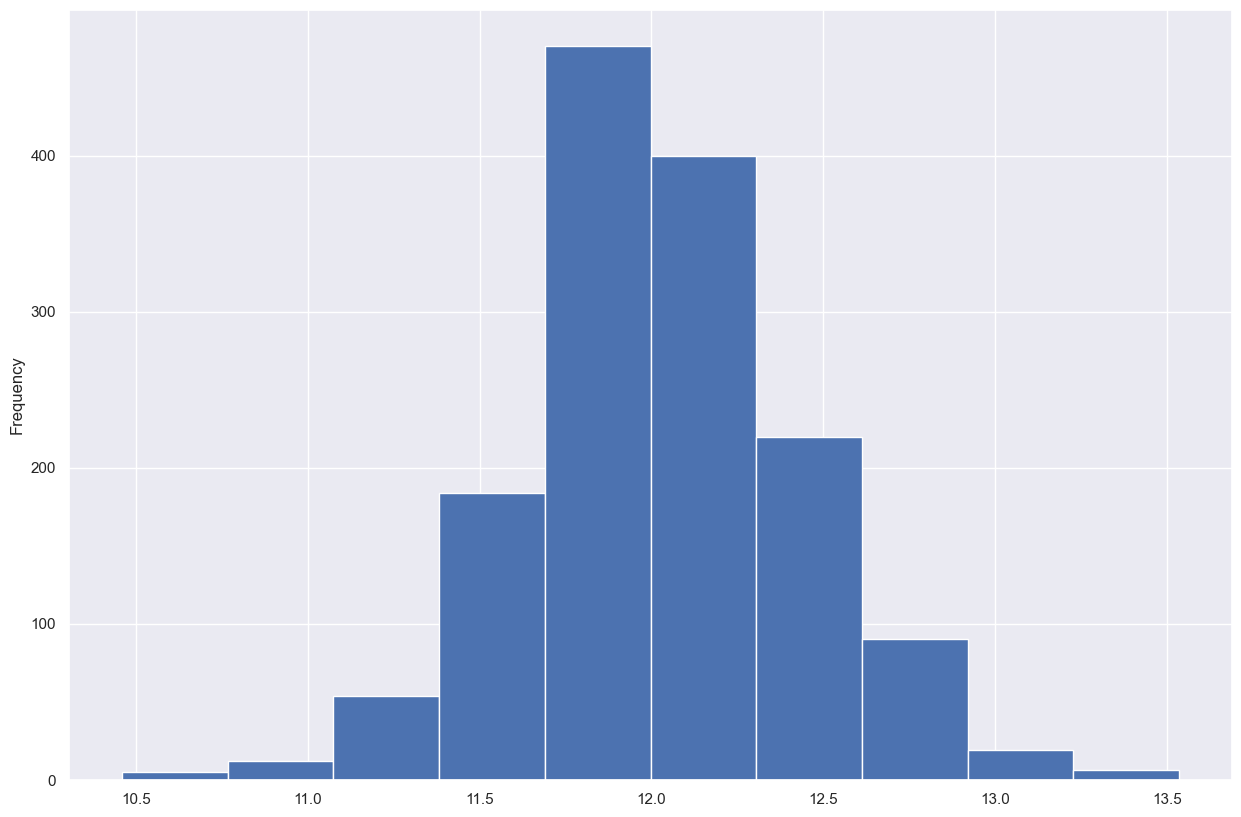

In [20]:
log_target.plot(kind='hist')

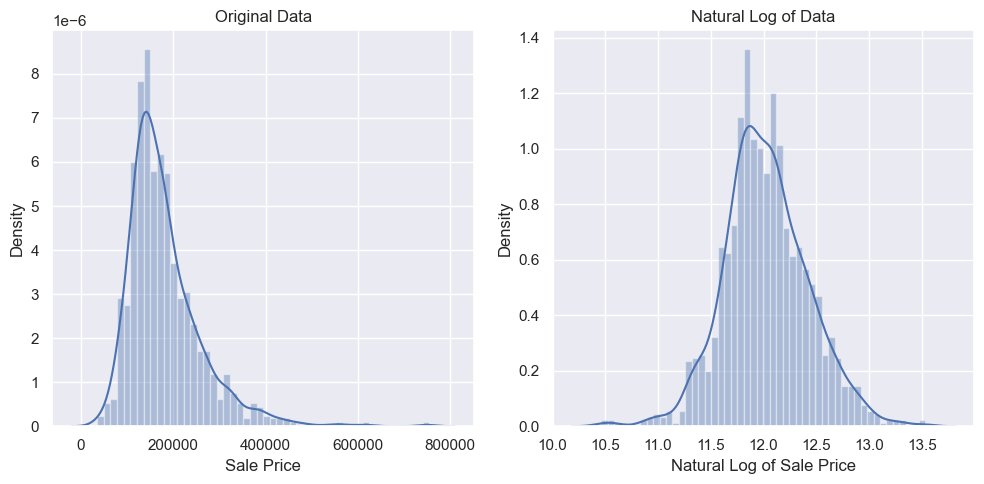

In [21]:
### Это позволяет получить нормальное распределение таргета
### Важно, например, для построения корректной
### С точки зрения статистических свойств
### Линейной модели.
### Хотя здесь мы будем строить ансамбли деревьев, 
### И это не особо интересно.

sns.set(rc={'figure.figsize': (15, 10)})

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.distplot(y, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1, 2, 2)
sns.distplot(log_target, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавьтесь от всех колонок, в которых пропусков оказывается больше 15%. (1б)

In [22]:
### Your code is here

cols_to_drop = df.columns[df.isna().sum() > X.shape[0] * 0.15]
X.drop(cols_to_drop, axis=1, inplace=True)

# или

X.dropna(axis=1, thresh=X.shape[0] * 0.85, inplace=True)

Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметьте, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Обработайте их как категориальные.

In [23]:
### Your code is here
X = X.astype(
    {'GarageYrBlt': 'object', 'MoSold': 'object', 'YrSold': 'object', 'YearBuilt': 'object', 'YearRemodAdd': 'object'})
num_cols = X.select_dtypes('number').columns
obj_cols = X.select_dtypes('object').columns

In [24]:
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())

for col in obj_cols:
    X[col] = X[col].fillna(X[col].mode().max())

In [25]:
X.to_csv('Data/task6.csv', index=False, sep=',')

In [26]:
### Отложенная выборка

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    log_target,
                                                    test_size=0.25,
                                                    random_state=1)

Напишите трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого советуем воспользоваться библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. Напомним, что для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, TargetEncoder

### Your code is here

cols_for_ohe = [x for x in obj_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in obj_cols if X_train[x].nunique() >= 5]
numeric_cols = list(X_train.select_dtypes('number').columns)

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

t = [('StandardScaler', StandardScaler(), numeric_cols_idx),
     ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)]

col_transform = ColumnTransformer(transformers=t)

Посмотрите, как на наших данных справляется одно Решающее Дерево с дефолтными гиперпараметрами. Добавьте написанный ранее трансформер в модель. (1б)

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

### Your code is here

pipe = Pipeline(steps=[('col_transform', col_transform),
                       ('tree', DecisionTreeRegressor(random_state=1))])

za = pipe.fit(X_train, y_train)
mean_squared_error(y_test, za.predict(X_test)).__round__(3)

0.043

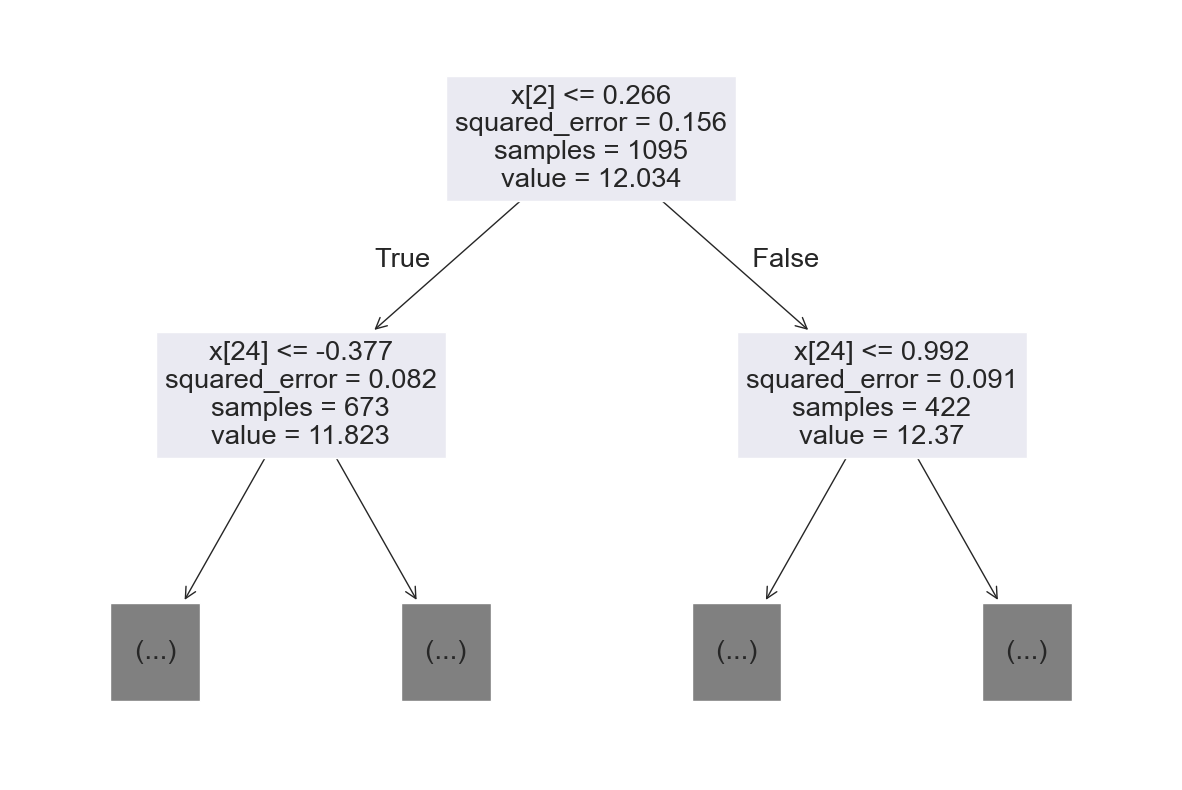

In [29]:
tree.plot_tree(za.steps[1][1], max_depth=1)
plt.show()

Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберите параметры по отложенной выборке по данной сетке `param_grid`. Помните, что подбирать количество деревьев не супер обязательно, достаточно поставить их побольше. Что произошло с качеством модели по сравнению с одиноким деревом? (2б)

In [14]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

### Your code is here

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[('col_transform', col_transform),
                       ('random_forest', RandomForestRegressor(random_state=1))])

gs = GridSearchCV(pipe, param_grid, verbose=10)
gs.fit(X_train, y_train)
# mean_squared_error(y_test, gs.best_estimator_.predict(X_test)).__round__(3)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 1/5; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=0.834 total time=   3.0s
[CV 2/5; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 2/5; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=0.854 total time=   2.8s
[CV 3/5; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 3/5; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=0.847 total time=   2.9s
[CV 4/5; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 4

GridSearchCV(estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('StandardScaler',
                                                                         StandardScaler(),
                                                                         [0, 2,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          22,
                                                                          30,
                                                                          32,
                                                                          33,
                                                                          34,
                                                                          39,
                                                                          40,
                                                                          41,
                                                                          42,
                                                                          43,
                                                                          44,
                                                                          45,
                                                                          46,
                                                                          47,
                                                                          48,
                                                                          50,
                                                                          52,
                                                                          54,
                                                                          56,
                                                                          57,
                                                                          61,
                                                                          62,
                                                                          63,
                                                                          64, ...]),
                                                                        ('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         [3, 4,
                                                                          5, 6,
                                                                          8, 23,
                                                                          26,
                                                                          27,
                                                                          28,
                                                                          36,
                                                                          37,
                                                                          49,
                                                                          55,
                                                                          60]),
                                                                        ('MeanTargetEncoder',
                                                                         TargetEncoder(),
                                                                         [1, 7,
                                                                          9, 10,
                                                                          11,
                    

In [15]:
mean_squared_error(y_test, gs.best_estimator_.predict(X_test)).__round__(3)

0.019

Попробуем теперь поэкспериментировать с бэггингами. 

Постройте бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!). 

Какое качество у каждой модели на тесте?

Какой алгоритм получился лучше с точки зрения качества на тесте? (2б)

In [30]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression

### Your code is here
bagging_pipe = Pipeline(steps=[('col_transform', col_transform),
                               ('bagging', BaggingRegressor(random_state=1, n_estimators=100))])

param_grid = {'bagging__estimator': [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]}
bagging_gs = GridSearchCV(bagging_pipe, param_grid, verbose=10)
bagging_gs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START bagging__estimator=LinearRegression().......................
[CV 1/5; 1/3] END bagging__estimator=LinearRegression();, score=-1027557099.198 total time=   1.3s
[CV 2/5; 1/3] START bagging__estimator=LinearRegression().......................
[CV 2/5; 1/3] END bagging__estimator=LinearRegression();, score=-42640207418.207 total time=   1.2s
[CV 3/5; 1/3] START bagging__estimator=LinearRegression().......................
[CV 3/5; 1/3] END bagging__estimator=LinearRegression();, score=-4064319082314.211 total time=   1.5s
[CV 4/5; 1/3] START bagging__estimator=LinearRegression().......................
[CV 4/5; 1/3] END bagging__estimator=LinearRegression();, score=-153804494741.995 total time=   1.2s
[CV 5/5; 1/3] START bagging__estimator=LinearRegression().......................
[CV 5/5; 1/3] END bagging__estimator=LinearRegression();, score=-681681062510.451 total time=   1.3s
[CV 1/5; 2/3] START bagging__est

GridSearchCV(estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('StandardScaler',
                                                                         StandardScaler(),
                                                                         [0, 2,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          22,
                                                                          30,
                                                                          32,
                                                                          33,
                                                                          34,
                                                                          39,
                                                                          40,
                                                                          41,
                                                                          42,
                                                                          43,
                                                                          44,
                                                                          45,
                                                                          46,
                                                                          47,
                                                                          48,
                                                                          50,
                                                                          52,
                                                                          54,
                                                                          56,
                                                                          57,
                                                                          61,
                                                                          62,
                                                                          63,
                                                                          64, ...]),
                                                                        ('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         [3, 4,
                                                                          5, 6,
                                                                          8, 23,
                                                                          26,
                                                                          27,
                                                                          28,
                                                                          36,
                                                                          37,
                                                                          49,
                                                                          55,
                                                                          60]),
                                                                        ('MeanTargetEncoder',
                                                                         TargetEncoder(),
                                                                         [1, 7,
                                                                          9, 10,
                                                                          11,
                    

In [41]:
bagging_gs.cv_results_['mean_test_score']

array([-9.88694481e+11,  8.64540995e-01,  8.66825888e-01])

In [43]:
mean_squared_error(y_test,bagging_gs.best_estimator_.predict(X_test)).__round__(3)

0.019

In [45]:
bagging_gs.best_estimator_

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  [0, 2, 14, 15, 16, 17, 22, 30,
                                                   32, 33, 34, 39, 40, 41, 42,
                                                   43, 44, 45, 46, 47, 48, 50,
                                                   52, 54, 56, 57, 61, 62, 63,
                                                   64, ...]),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [3, 4, 5, 6, 8, 23, 26, 27,
                                                   28, 36, 37, 49, 55, 60]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [1, 7, 9, 10, 11, 12, 13, 16,
                                                   17, 18, 19, 20, 21, 24, 25,
                                                   29, 31, 35, 38, 51, 53, 54,
                                                   58, 59, 68, 69, 70, 71])])),
                ('bagging',
                 BaggingRegressor(estimator=RandomForestRegressor(),
                                  n_estimators=100, random_state=1))])

In [60]:
from sklearn.ensemble import StackingRegressor


stacking_pipe = Pipeline(steps=[('col_transform', col_transform),
                                ('random_forest',RandomForestRegressor(max_depth=30))])


stacking_model1 = StackingRegressor(
    estimators=[('stacking_estimator', stacking_pipe)],
    final_estimator=RandomForestRegressor(max_depth=30),
    cv=2,
    verbose=10
)

stacking_model2 = StackingRegressor(
    estimators=[('stacking_model1', stacking_model1)],
    final_estimator=LinearRegression(),
    cv=2,
    verbose=10
)
stacking_model2.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.6s


StackingRegressor(cv=2,
                  estimators=[('stacking_model1',
                               StackingRegressor(cv=2,
                                                 estimators=[('stacking_estimator',
                                                              Pipeline(steps=[('col_transform',
                                                                               ColumnTransformer(transformers=[('StandardScaler',
                                                                                                                StandardScaler(),
                                                                                                                [0,
                                                                                                                 2,
                                                                                                                 14,
                                                                                                                 15,
                                                                                                                 16,
                                                                                                                 17,
                                                                                                                 22,
                                                                                                                 30,
                                                                                                                 32,
                                                                                                                 33,
                                                                                                                 34,
                                                                                                                 39,
                                                                                                                 40,
                                                                                                                 41,
                                                                                                                 42,
                                                                                                                 43,
                                                                                                                 44,
                                                                                                                 45,
                                                                                                                 46,
                                                                                                                 47,
                                                                                                                 48,
                                                                                                                 50,
                                                                                                                 52,
                                                                                                                 54,
                                                                                                                 56,
                                                                                                                 57,
                                                                                                                 61,
                                                                                                                 62,
                                                                                                                 63,
                                        

In [61]:
mean_squared_error(y_test,stacking_model2.predict(X_test))

0.026848836226261753

Улучшил ли бэггинг над Лесом качество по сравнению с одним Лесом с точки зрения как качества на тесте, так и на трейне. Как это можно объяснить? Как думаете, много ли смысла в использовании бэггинга над линейными моделями? Выбрали бы вы в данной ситуации именно их в качестве базовых?

### Добавим новые фичи!

Создайте следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучите заново Случайный лес и найдите лучшие гиперпараметры на старой сетке.

Улучшили ли качество модели новые фичи? (4б)

In [73]:
### Your code is here
X['1stToAll'] = X['1stFlrSF'] / X['GrLivArea'] * 100
X['NewCol'] = X['BsmtFinSF1'] / X['TotalBsmtSF'] * 100
X['HouseAge'] = X['YrSold'].astype('int32') - X['YearBuilt'].astype('int32')
X['OverallSF'] = X['1stFlrSF'] + X['2ndFlrSF'] + X['TotalBsmtSF']

param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    log_target,
                                                    test_size=0.25,
                                                    random_state=1)

cols_for_ohe = [x for x in obj_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in obj_cols if X_train[x].nunique() >= 5]
numeric_cols = list(X_train.select_dtypes('number').columns)

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

t = [('StandardScaler', StandardScaler(), numeric_cols_idx),
     ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)]

col_transform = ColumnTransformer(transformers=t)

pipe = Pipeline(steps=[('col_transform', col_transform),
                       ('random_forest', RandomForestRegressor(random_state=1))])

gs_tree_last = GridSearchCV(pipe, param_grid, verbose=10)
gs_tree_last.fit(X_train, y_train)
mean_squared_error(y_test, gs_tree_last.predict(X_test)).__round__(3)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 1/5; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=0.821 total time=   1.4s
[CV 2/5; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 2/5; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=0.852 total time=   1.3s
[CV 3/5; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 3/5; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=0.872 total time=   1.2s
[CV 4/5; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 4

0.019